## 1. Introduction

### Things we are going to do:
* Write the perfect code for Training, Validating and Testing the Network
* Use Transfer Learning
* Use Albumentations for Transforms
* tqdm



### After this:
* Create activation maps
* Use mixed precision training
* we will convert the code to pytorch lightning
* Use the features from the penultimate layer of your from-scratch CNN or transfer-learned CNN to implement an image retrieval algorithm. Your algorithm should roughly perform the following procedure: given an image, extract the CNN features for the image, compute the dot product between the aforementioned CNN features and the CNN features for each of the images in landmark_images, return the images that have the highest dot product values.
* Use self supervised learning with lightly
* Model interpretability

## 2. Import libraries

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

### 3. Define Params

In [19]:
####################################################
#                Define parameters
####################################################

params = {
#    "model": "resnet50",
    #"device": "cuda",
#    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "n_epochs": 10,
    "image_size": 256, 
    "in_channels": 3, 
    "num_classes": 5
}



### 4. Define Transform

In [20]:
#######################################################
#               Define Transforms
#######################################################

train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=params["image_size"], width=params["image_size"]),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=params["image_size"], width=params["image_size"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

### 5. Load Dataset

In [21]:
train_data_path = 'images/train'
test_data_path = 'images/test'

In [22]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = 'images/train'
test_data_path = 'images/test'

train_image_paths = []
classes = []

for data_path in glob.glob(train_data_path + '/*')[:params['num_classes']]:
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))
    

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)
#split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 


test_image_paths = []
for data_path in glob.glob(test_data_path + '/*')[:params['num_classes']]:
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 400
Valid size: 100
Test size: 125


In [23]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}


In [24]:
idx_to_class

{0: '42.Death_Valley_National_Park',
 1: '39.Gateway_of_India',
 2: '13.Yellowstone_National_Park',
 3: '44.Trevi_Fountain',
 4: '32.Hanging_Temple'}

In [25]:
print('Length of train: ', len(train_image_paths))
print('Length of test: ', len(test_image_paths))

Length of train:  400
Length of test:  125


In [26]:
#######################################################
#               Define Dataset Class
#######################################################

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [27]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=params["batch_size"], shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False
)

loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}




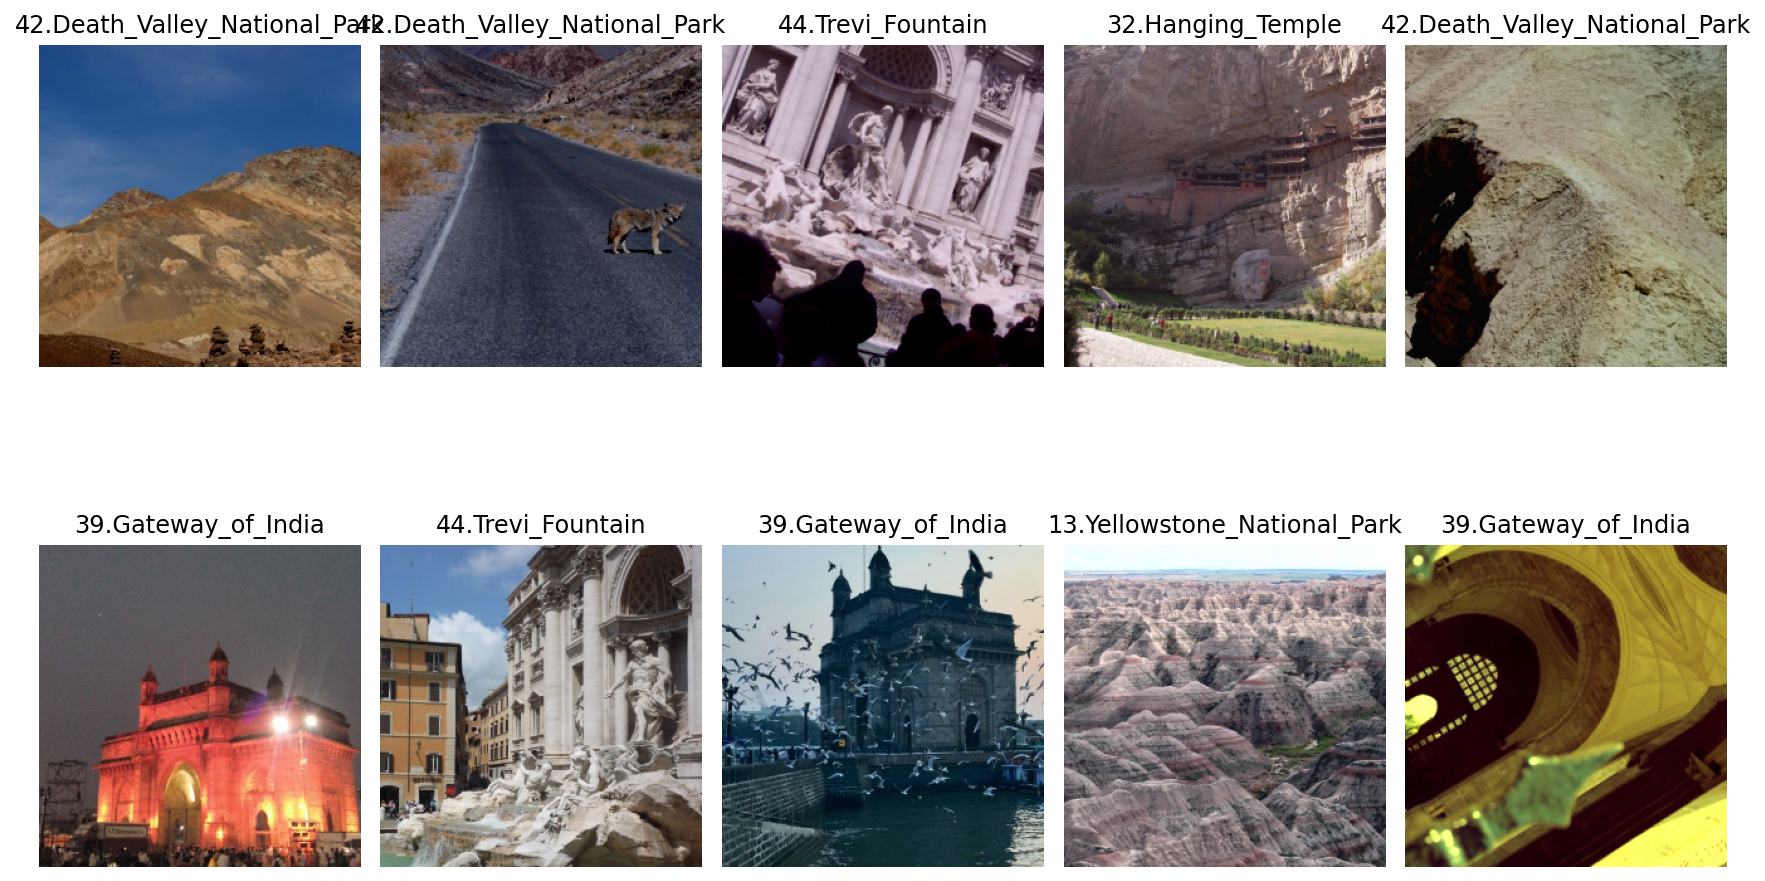

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [29]:
# useful variable that tells us whether we should use the GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### 6. Train

In [30]:
num_classes = len(classes)
num_classes

5

In [61]:
def Net(num_classes):
    model = models.resnet18(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(512, 256)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(256, num_classes)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.fc = classifier
    return model

model = Net(params['num_classes'])
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [68]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader):
    #put model in training state
    model.train()
    
    train_loss = 0.0
    
    
    
    #for batch_idx, (imgs, labels) in enumerate(train_loader):  
    tqdm_loop = tqdm(enumerate(train_loader), total = len(train_loader))
    
    for batch_idx, (imgs, labels) in tqdm_loop:  
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = loss_fn(preds, labels)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
    
        train_loss+= ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        #if batch_idx%5==0:
        #    print('train loss', train_loss)
        
        #set tqdm
        tqdm_loop.set_description(f"Epoch [{epoch}]")
        tqdm_loop.set_postfix(loss = train_loss)
    print('Epoch {} avg Training loss: {:.3f}'.format(epoch+1, train_loss))
    return model, train_loss
        
def test_one_epoch(epoch, model, loss_fn, loader, img_paths):
    model.eval()
    
    #pbar = tqdm(enumerate(test_loader), total = len(test_loader))
    running_loss = 0
    actual_labels = []
    pred_labels = []
    
    #for step, (imgs, labels) in pbar:
    for batch_idx, (imgs, labels) in enumerate(loader):    
        imgs, labels = imgs.to(device), labels.to(device)
        log_preds = model(imgs)
        loss = loss_fn(log_preds, labels)
        
        
        preds = torch.exp(log_preds)
        running_loss+=((1 / (batch_idx + 1)) * (loss.data.item() - running_loss))
        
        #calculate accuracy
        top_prob, top_class = preds.topk(1, dim=1)
        pred_labels+= list((top_class.view(-1)).numpy())
        actual_labels+= list(labels.numpy())
        
        
    
    accuracy = ((np.array(pred_labels)==np.array(actual_labels)).sum())/len(img_paths) #size of test set
    correct = ((np.array(pred_labels)==np.array(actual_labels)).sum())
    total = len(img_paths)
    
    
    return running_loss, accuracy, correct, total



In [69]:
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [70]:
train_losses = []
valid_losses = []
for epoch in range(params['n_epochs']):
    train_loss = train_one_epoch(epoch, model, loss_fn, optimizer, train_loader)
    train_losses+= [train_loss]
    
    
    valid_loss, accuracy, correct, total = test_one_epoch(epoch, model, loss_fn, valid_loader, valid_image_paths)
    valid_losses+=[valid_loss]
    print('Epoch {} avg Valid loss: {:.3f}'.format(epoch+1, valid_loss))
    print('Epoch {} Valid accuracy: {:.1%} ({} of {} right)\n'.format(epoch+1, accuracy, correct, total))
    
    if len(valid_losses)>1 and (valid_loss<min(valid_losses[:-1])):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            'train_transforms': train_transforms,
            'test_transforms': test_transforms,
            }, 'checkpoint.tar')

Epoch [0]: 100%|██████████| 25/25 [00:51<00:00,  2.06s/it, loss=1.34]


Epoch 1 avg Training loss: 1.342


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 avg Valid loss: 0.884
Epoch 1 Valid accuracy: 64.0% (64 of 100 right)



Epoch [1]:  12%|█▏        | 3/25 [00:08<00:59,  2.70s/it, loss=1.13]


KeyboardInterrupt: 

### Testing the model

In [ ]:
# load the model that got the best validation accuracy
checkpoint = torch.load('checkpoint.tar')
loaded_model = Net(params['num_classes'])
loaded_model.load_state_dict(checkpoint['model_state_dict'])

loaded_criterion = checkpoint['loss']

#optimizer = optim.Adam(model.parameters(), lr = 0.003)
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

last_epoch = checkpoint['epoch']+1

test_loss, accuracy, correct, total = test_one_epoch(None, loaded_model, loaded_criterion, test_loader, test_image_paths)

print('Test loss: {:.3f}'.format(test_loss))
print('Test accuracy: {:.1%} ({} of {} right)\n'.format(accuracy, correct, total))
    